### Import libraries and custom functions

In [1]:
# libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

# custom functions
from CleanData import *
from MergeData import *
from AugmentData import *
from CorrectHeading import *
from PlotData import *

### Correct, augment, and combine data

In [2]:
windspeeds = ["30cms", "40cms", "60cms"]

for windspeed in windspeeds:
    # import data 
    trajec_df = pd.read_hdf(f"../ExperimentalData/{windspeed}/flight_trajectories_3d_HCS_odor_horizon_matched.h5")
    body_df = pd.read_hdf(f"../ExperimentalData/{windspeed}/body_orientations_HCS_odor_horizon_matched.h5")
    key_table = pd.read_hdf(f"../ExperimentalData/{windspeed}/body_trajec_matches.h5")

    # correct and synchronize data
    trajec_df = correct_for_wind(trajec_df)
    trajec_df = remove_irrelevant_trajectory_data(trajec_df)
    synced_trajectory = sync_time(trajec_df)
    body_df = remove_irrelevant_body_data(body_df)
    synced_body = sync_time(body_df)

    # merge all trajectory and body dfs 
    all_flies_body_and_trajectory = join_all_body_and_trajectory(synced_body, synced_trajectory, key_table)

    # only consider dfs at or longer than 5 time steps
    filtered_dfs = [df for df in all_flies_body_and_trajectory if len(df) > 12]

    # augment fly dfs with addition fields for neural network
    augmented_all_flies_body_and_trajectory = [augment_df(fly_body_and_trajectory) for fly_body_and_trajectory in filtered_dfs]

    # concatenate all dataframes vertically
    fly_data = pd.concat(augmented_all_flies_body_and_trajectory, ignore_index=True)
    fly_data.to_csv(f"../ExperimentalData/{windspeed}_corrected_fly_trajectories_with_body_orientations.csv",index=False)

In [3]:
# Read and concatenate all CSV files
file_paths = ["../ExperimentalData/30cms_corrected_fly_trajectories_with_body_orientations.csv",
              "../ExperimentalData/40cms_corrected_fly_trajectories_with_body_orientations.csv",
              "../ExperimentalData/60cms_corrected_fly_trajectories_with_body_orientations.csv"]
dataframes = [pd.read_csv(file) for file in file_paths]
combined_df = pd.concat(dataframes, ignore_index=True)

# Save the combined DataFrame to a new CSV file
combined_df.to_csv('../ExperimentalData/combined_corrected_fly_trajectories_with_body_orientations.csv', index=False)

In [4]:
windspeeds = ["30cms", "40cms", "60cms"]

def import_and_clean_fly_data(windspeed="30cms"):
    # import data 
    trajec_df = pd.read_hdf(f"../ExperimentalData/{windspeed}/flight_trajectories_3d_HCS_odor_horizon_matched.h5")
    body_df = pd.read_hdf(f"../ExperimentalData/{windspeed}/body_orientations_HCS_odor_horizon_matched.h5")
    key_table = pd.read_hdf(f"../ExperimentalData/{windspeed}/body_trajec_matches.h5")

    # correct and synchronize data
    trajec_df = correct_for_wind(trajec_df)
    trajec_df = remove_irrelevant_trajectory_data(trajec_df)
    synced_trajectory = sync_time(trajec_df)
    body_df = remove_irrelevant_body_data(body_df)
    synced_body = sync_time(body_df)

    # merge all trajectory and body dfs 
    all_flies_body_and_trajectory = join_all_body_and_trajectory(synced_body, synced_trajectory, key_table)

    # only consider dfs at or longer than 5 time steps
    filtered_dfs = [df for df in all_flies_body_and_trajectory if len(df) > 12]

    # concatenate all dataframes vertically
    fly_data = pd.concat(filtered_dfs, ignore_index=True)
    return fly_data

In [5]:
fly_30 = import_and_clean_fly_data(windspeed="30cms")
fly_40 = import_and_clean_fly_data(windspeed="40cms")
fly_60 = import_and_clean_fly_data(windspeed="60cms")

In [6]:
all_fly_data = pd.concat([fly_30,fly_40,fly_60], ignore_index=True)

In [7]:
test_fly = all_fly_data.loc[all_fly_data["trajec_objid"]=="20130410_185709_5331"].reset_index(drop=True)

In [8]:
test_fly.head()

,trajec_objid,timestamp,position_x,position_y,velocity_x,velocity_y,airvelocity_x,airvelocity_y,wind_speed,eccentricity,ellipse_short_angle
0,20130410_185709_5331,1.61,0.203033,0.013733,-0.091000,0.275387,-0.691000,0.275387,0.6,0.500000,0.670505
1,20130410_185709_5331,1.62,0.202146,0.016509,-0.086795,0.280024,-0.686795,0.280024,0.6,0.655764,-2.306360
2,20130410_185709_5331,1.63,0.201278,0.019334,-0.088156,0.284984,-0.688156,0.284984,0.6,0.514622,0.756163
3,20130410_185709_5331,1.64,0.200363,0.022206,-0.095484,0.289130,-0.695484,0.289130,0.6,0.539953,0.705661
4,20130410_185709_5331,1.65,0.199360,0.025113,-0.105429,0.292016,-0.705429,0.292016,0.6,0.500000,-2.356194


In [10]:
test_fly.to_csv('../ExperimentalData/20130410_185709_5331.csv', index=False)

In [18]:
test_fly = pd.read_csv('../ExperimentalData/20130410_185709_5331.csv')

In [19]:
from AugmentData import _compute_angular_acceleration,_linear_acceleration,_compute_angular_velocity,_tranform_short_axis_to_heading_angle,_transform_timestamps_to_start_at_zero,_linear_acceleration

In [20]:
def _tranform_short_axis_to_heading_angle(angle):
    angle = np.where(angle < 0, angle - np.pi / 2, angle)
    angle = np.where(angle > 0, angle + np.pi / 2, angle)
    return angle

In [21]:
import utils
import scipy
import numpy as np
from AugmentData import *
from cvxpy.atoms.norm import norm
from cvxpy.expressions.expression import Expression

def correct_heading_jumps(traj):
    """
    The heading values randomly jump 180 degrees. This function corrects for such jumps.

    Parameters:
    - fly_data (pd.DataFrame): initial df of fly data

    Returns:
    - corrected_fly_data (pd.DataFrame): fly data with corrected heading angles
    """

    def circular_distance(angle1, angle2):
        """
        Calculate the shortest distance between two angles on a 2D circle.
        
        Parameters:
        angle1, angle2: Angles in radians.
        
        Returns:
        float: Shortest distance between the two angles on the circle.
        """
        # Normalize angles to range [0, 2π)
        angle1 = angle1 % (2 * np.pi)
        angle2 = angle2 % (2 * np.pi)
        
        # Calculate the direct distance and the wrapped-around distance
        direct_distance = np.abs(angle1 - angle2)
        wrapped_distance = 2 * np.pi - direct_distance
        
        # Return the shorter of the two distances
        return min(direct_distance, wrapped_distance)
    
    traj_add = traj.copy()

    # Heading
    angle = traj_add['heading_angle'].values # heading_angle

    # Align initial heading with course direction
    initial_window = 5
    course_direction = traj_add["groundspeed_angle"]
    circ_diff_start = circular_distance(scipy.stats.circmean(course_direction[0:initial_window], low=-np.pi, high=np.pi),
                                        scipy.stats.circmean(angle[0:initial_window], low=-np.pi, high=np.pi))
    if circ_diff_start > 0.5*np.pi:
        angle = angle + np.pi * np.sign(circ_diff_start) 

    # Correct heading
    corrected_heading_angle = np.unwrap(angle, period=np.pi, discont=0.5*np.pi)  # use unwrap function to detect pi flips
    
    # Align heading
    phi_mean = scipy.stats.circmean(utils.wrapToPi(corrected_heading_angle), low=-np.pi, high=np.pi)
    psi_mean = scipy.stats.circmean(utils.wrapToPi(course_direction), low=-np.pi, high=np.pi)
    circ_diff = circular_distance(phi_mean, psi_mean)
    
    if circ_diff > 0.5*np.pi:
        corrected_heading_angle = corrected_heading_angle + np.pi * np.sign(circ_diff)
     
    corrected_heading_angle = utils.wrapToPi(corrected_heading_angle)  # wrap
    
    return corrected_heading_angle

In [22]:
def augment_df(fly_trajectory_and_body):
    gnd_velocity_x, gnd_velocity_y = fly_trajectory_and_body["velocity_x"],fly_trajectory_and_body["velocity_y"]
    fly_trajectory_and_body["groundspeed"] = np.sqrt(gnd_velocity_x**2 + gnd_velocity_y**2)
    fly_trajectory_and_body["groundspeed_angle"] = np.arctan2(gnd_velocity_y,gnd_velocity_x)
    
    airspeed_x, airspeed_y = fly_trajectory_and_body["airvelocity_x"],fly_trajectory_and_body["airvelocity_y"]
    fly_trajectory_and_body["airspeed"] = np.sqrt(airspeed_x**2 + airspeed_y**2)
    fly_trajectory_and_body["airspeed_angle"] = np.arctan2(airspeed_y,airspeed_x)
    
    thrust_x, thrust_y = thrust(fly_trajectory_and_body)
    fly_trajectory_and_body["thrust"] = np.sqrt(thrust_x ** 2 + thrust_y ** 2)
    fly_trajectory_and_body["thrust_angle"] = np.arctan2(thrust_y, thrust_x)

    accel_x, accel_y = _linear_acceleration(fly_trajectory_and_body)
    fly_trajectory_and_body["linear_acceleration"] = np.sqrt(accel_x ** 2 + accel_y ** 2)
    fly_trajectory_and_body["linear_acceleration_angle"] = np.arctan2(accel_y, accel_x)
    
    fly_trajectory_and_body = _transform_timestamps_to_start_at_zero(fly_trajectory_and_body)
    fly_trajectory_and_body["heading_angle"] = _tranform_short_axis_to_heading_angle(fly_trajectory_and_body['ellipse_short_angle'])
    fly_trajectory_and_body["heading_angle"] = correct_heading_jumps(fly_trajectory_and_body)
    
    fly_trajectory_and_body["angular_velocity"] = _compute_angular_velocity(fly_trajectory_and_body)
    fly_trajectory_and_body["angular_acceleration"] = _compute_angular_acceleration(fly_trajectory_and_body)
    return fly_trajectory_and_body

In [23]:
augmented_test_fly = augment_df(test_fly)

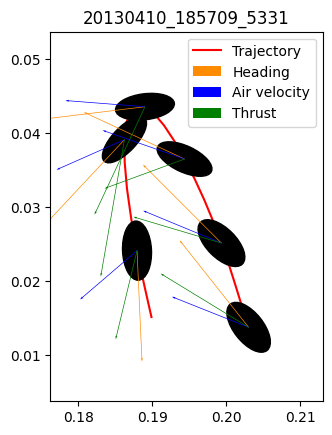

In [24]:
plot_trajectory(augmented_test_fly,every_nth=4)